## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

In [1]:
# Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [2]:
# Setting up the data
np.random.seed(42)

n = 100  # Sample size

# True parameters
true_mu = 0.0
true_sigma2 = 1.0
true_nu = 5

# Simulate using the standard Student's t (with true_nu) and then scale & shift:
x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)


# Log-likelihood for the location-scale t distribution
def log_likelihood(mu, sigma2, nu, data):
    n = len(data)
    term1 = gammaln((nu+1)/2) - gammaln(nu/2)
    term2 = -0.5*np.log(np.pi * nu * sigma2)
    ll = 0.0
    for xi in data:
        # Using the density: (1 + (xi-mu)^2/(nu*sigma2))^(-(nu+1)/2)
        ll += term1 + term2 - ((nu+1)/2) * np.log(1 + (xi-mu)**2/(nu*sigma2))
    return ll

# Log prior for mu ~ N(mu0, 1/tau0)
def log_prior_mu(mu, mu0, tau0):
    return 0.5 * np.log(tau0/(2*np.pi)) - 0.5 * tau0 * (mu - mu0)**2

# Log prior for sigma^2 ~ half-normal (on sigma^2) with scale sigma0
def log_prior_sigma2(sigma2, sigma0):
    # density is sqrt(2/(pi*sigma0^2))*exp[-(sigma2^2)/(2*sigma0^2)] for sigma2 > 0.
    if sigma2 <= 0:
        return -np.inf
    return 0.5 * np.log(2/(np.pi * sigma0**2)) - (sigma2**2)/(2*sigma0**2)

# Log prior for nu ~ discrete uniform on {1,...,100}
def log_prior_nu(nu):
    if nu < 1 or nu > 100:
        return -np.inf
    return -np.log(100)

# Full log-posterior (up to a constant)
def log_posterior(mu, sigma2, nu, data, mu0, tau0, sigma0):
    return (log_likelihood(mu, sigma2, nu, data) +
            log_prior_mu(mu, mu0, tau0) +
            log_prior_sigma2(sigma2, sigma0) +
            log_prior_nu(nu))



# Initialize MCMC parameters
num_iter = 8000  # Number of MCMC samples
burn_in = 2000

mu_samples = np.zeros(num_iter)
sigma2_samples = np.zeros(num_iter)
nu_samples = np.zeros(num_iter, dtype=int)

# Hyperparameters for the priors:
mu0 = 0.0
tau0 = 1.0
sigma0 = 1.0  # scale for the half-normal on sigma^2

# Metropolis proposal standard deviations
s_mu = 0.3          # for mu update 
s_log_sigma2 = 0.3  # for log(sigma2) update

# Storage for samples
mu_samples = np.zeros(num_iter)
sigma2_samples = np.zeros(num_iter)
nu_samples = np.zeros(num_iter, dtype=int)

# Initialize parameters
mu_current = np.mean(x)
sigma2_current = np.var(x)
nu_current = 10   # start with a moderate nu

current_log_post = log_posterior(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)


# MCMC sampler (Gibbs-with-MH for continuous params and direct sampling for nu)
for it in range(num_iter):
    # Update mu using MH
    mu_prop = stats.norm.rvs(loc=mu_current, scale=s_mu)
    log_post_prop = log_posterior(mu_prop, sigma2_current, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < (log_post_prop - current_log_post):
        mu_current = mu_prop
        current_log_post = log_post_prop

    # Update sigma^2 using MH on the log scale 
    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_prop = stats.norm.rvs(loc=log_sigma2_current, scale=s_log_sigma2)
    sigma2_prop = np.exp(log_sigma2_prop)
    log_post_prop = log_posterior(mu_current, sigma2_prop, nu_current, x, mu0, tau0, sigma0)
    
    # include Jacobian adjustment: proposal density ratio = sigma2_prop / sigma2_current
    log_accept_ratio = log_post_prop - current_log_post + np.log(sigma2_prop) - np.log(sigma2_current)
    if np.log(np.random.rand()) < log_accept_ratio:
        sigma2_current = sigma2_prop
        current_log_post = log_post_prop

    # Update nu (discrete), the (unnormalized) log probability for each candidate nu in {1,...,100}
    log_probs = np.array([log_likelihood(mu_current, sigma2_current, nu_candidate, x) +
                            log_prior_nu(nu_candidate)
                            for nu_candidate in range(1, 101)])
    
    # To avoid numerical issues, subtract the maximum log probability
    log_probs -= np.max(log_probs)
    probs = np.exp(log_probs)
    probs /= probs.sum()
    # Sample a new nu from 1,...,100
    nu_current = np.random.choice(np.arange(1, 101), p=probs)
    # Update the current log posterior to reflect the new nu:
    current_log_post = log_posterior(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

    # Store samples
    mu_samples[it] = mu_current
    sigma2_samples[it] = sigma2_current
    nu_samples[it] = nu_current

# Discard burn-in
mu_samples = mu_samples[burn_in:]
sigma2_samples = sigma2_samples[burn_in:]
nu_samples = nu_samples[burn_in:]

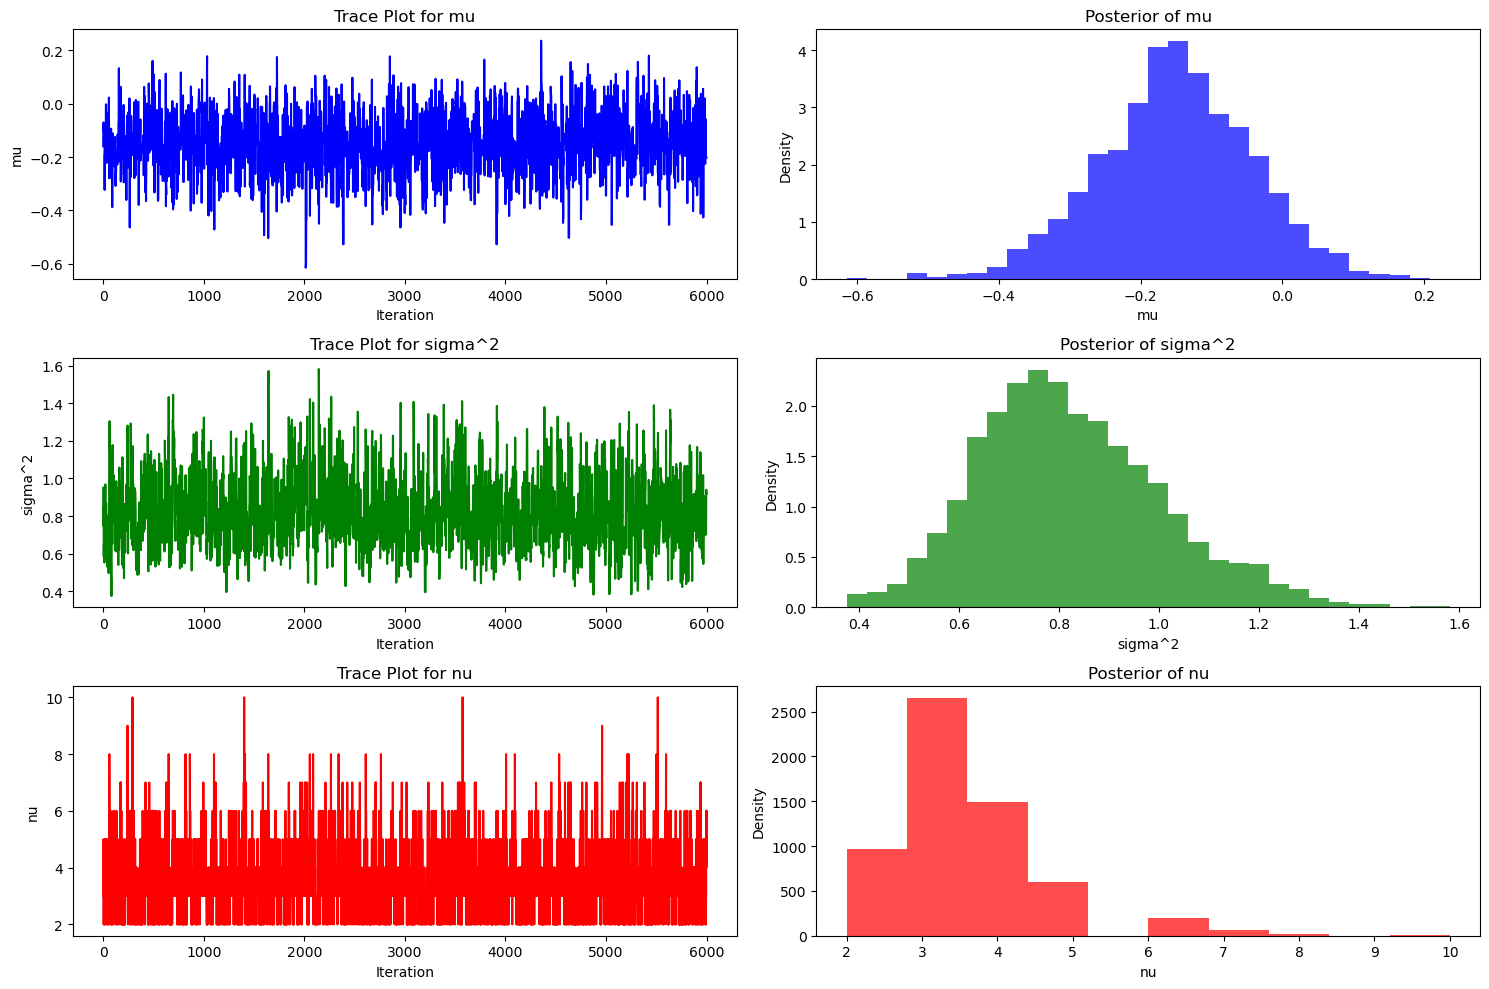

In [3]:
# ----- Plotting the results -----
plt.figure(figsize=(15, 10))

# Trace plot for mu
plt.subplot(3, 2, 1)
plt.plot(mu_samples, color='blue')
plt.xlabel("Iteration")
plt.ylabel("mu")
plt.title("Trace Plot for mu")

# Histogram for mu
plt.subplot(3, 2, 2)
plt.hist(mu_samples, bins=30, density=True, color='blue', alpha=0.7)
plt.xlabel("mu")
plt.ylabel("Density")
plt.title("Posterior of mu")

# Trace plot for sigma^2
plt.subplot(3, 2, 3)
plt.plot(sigma2_samples, color='green')
plt.xlabel("Iteration")
plt.ylabel("sigma^2")
plt.title("Trace Plot for sigma^2")

# Histogram for sigma^2
plt.subplot(3, 2, 4)
plt.hist(sigma2_samples, bins=30, density=True, color='green', alpha=0.7)
plt.xlabel("sigma^2")
plt.ylabel("Density")
plt.title("Posterior of sigma^2")

# Trace plot for nu (discrete parameter)
plt.subplot(3, 2, 5)
plt.plot(nu_samples, color='red')
plt.xlabel("Iteration")
plt.ylabel("nu")
plt.title("Trace Plot for nu")

# Histogram for nu
plt.subplot(3, 2, 6)
plt.hist(nu_samples, color='red', alpha=0.7)
plt.xlabel("nu")
plt.ylabel("Density")
plt.title("Posterior of nu")

plt.tight_layout()
plt.show()


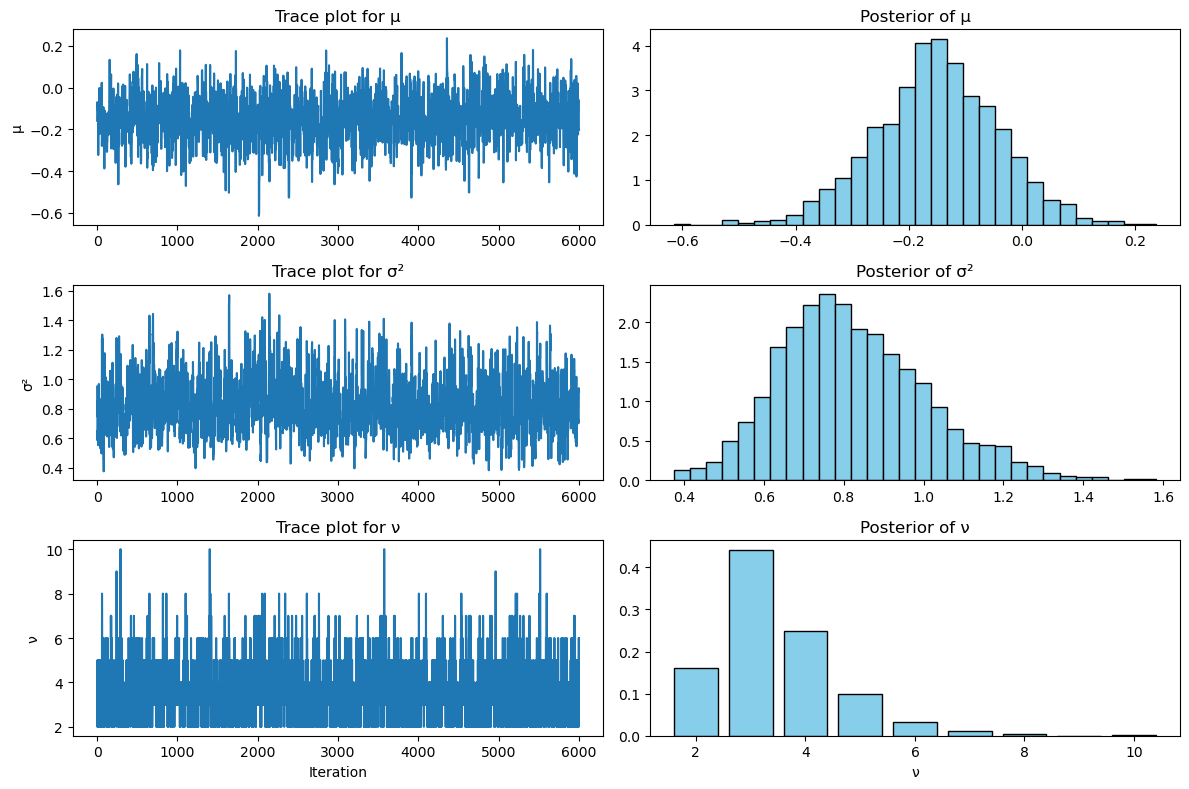

In [4]:
# Plot
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Trace plots
# Trace plot for mu
axs[0, 0].plot(mu_samples)
axs[0, 0].set_title('Trace plot for μ')
axs[0, 0].set_ylabel('μ')

# Trace plot for sigma^2 
axs[1, 0].plot(sigma2_samples)
axs[1, 0].set_title('Trace plot for σ²')
axs[1, 0].set_ylabel('σ²')

# Trace plot for nu
axs[2, 0].plot(nu_samples)
axs[2, 0].set_title('Trace plot for ν')
axs[2, 0].set_ylabel('ν')
axs[2, 0].set_xlabel('Iteration')

# Histograms of Posterior densities
# Histogram for mu
axs[0, 1].hist(mu_samples, bins=30, density=True, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Posterior of μ')

# Histogram for sigma^2 
axs[1, 1].hist(sigma2_samples, bins=30, density=True, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Posterior of σ²')

# Bar plot for nu
unique, counts = np.unique(nu_samples, return_counts=True)
axs[2, 1].bar(unique, counts/len(nu_samples), color='skyblue', edgecolor='black')
axs[2, 1].set_title('Posterior of ν')
axs[2, 1].set_xlabel('ν')


plt.tight_layout()
plt.show()


### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*



In [5]:
# Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [6]:
# Set random seed
np.random.seed(42)

# Different sample sizes to test
sample_sizes = [50, 100, 500, 900]

# True parameters
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

# Store inference results
results = {}

for n in sample_sizes:
    # Generate synthetic data from a Student's t-distribution
    x = true_mu + true_sigma * stats.t.rvs(df=true_nu, size=n)
    
    # Define PyMC model
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        
        x_obs = pm.StudentT("x_obs", nu=nu, mu=mu, sigma=sigma, observed=x)
        
        # Inference
        trace = pm.sample(2000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.9)
    
    results[n] = trace

# Summarize results
display({n: az.summary(results[n], var_names=["nu"]) for n in sample_sizes})


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


{50:       mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
 nu  55.787  26.707    13.0     99.0       0.96    0.679     798.0     990.0   
 
     r_hat  
 nu    1.0  ,
 100:      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
 nu  2.105  0.656     1.0      3.0      0.051    0.036     141.0      97.0   
 
     r_hat  
 nu   1.03  ,
 500:      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
 nu  7.482  2.602     4.0     12.0       0.17    0.121     260.0     309.0   
 
     r_hat  
 nu   1.01  ,
 900:      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
 nu  7.118  1.571     5.0     10.0       0.08    0.056     379.0     469.0   
 
     r_hat  
 nu    1.0  }

We can see that small sample sizes with 50, posterior distribution for $v$ is quite dispersed, indicating that the data do not contain enough information to precisely determine the tail thickness. $v's$ posterior may fluctuate over a wide range, reflecting considerable uncertainty.

Moderate sample sizes with 100 and 500, as the sample size increases, the posterior distribution starts to concentrate within a narrower interval. Compared to a small sample, the data provide more information, leading to more accurate inference on $v$.

The posterior distribution of larger sample sizes over 500 becomes even more concentrated, clearly clustering around the true value ($v=5$ in this case). This demonstrates that when the sample size is sufficiently large, the data can significantly reduce the uncertainty in $v$, yielding a more precise estimate of the tail thickness.

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



#### Q3
We need to derive the posterior predictive distribution by integrating out the uncertainty in ( $\tau_i$):

 $$
p(y_i) = \int p(y_i | \tau_i) p(\tau_i) d\tau_i
 $$

#### **Step 1: Define the Given Distributions**
We have:

- p($\tau_i$) follows a Gamma distribution:
  
  $$
  \tau_i \sim \text{Gamma} \left( \frac{\nu}{2}, \frac{\nu}{2} \right)
  $$

  This means its probability density function (PDF) is:

  $$
  p(\tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \tau_i^{\nu/2 - 1} e^{-\frac{\nu}{2} \tau_i}
  $$


- p($y_i | \tau_i$)  follows a Normal distribution:

  $$
  y_i | \tau_i \sim N(0, \tau_i^{-1})
  $$


- Thus, the likelihood is: 

  $$
  p(y_i | \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2}
  $$

#### **Step 2: Compute the Integral**
We need to evaluate:

$$
p(y_i) = \int p(y_i | \tau_i) p(\tau_i) d\tau_i
$$

Substituting the given expressions:

$$
p(y_i) = \int \left( \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \right) \cdot \left( \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \tau_i^{\nu/2 - 1} e^{-\frac{\nu}{2} \tau_i} \right) d\tau_i
$$

Rearrange the terms:

$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \sqrt{\frac{1}{2\pi}} \int \tau_i^{\nu/2 - 1 + 1/2} e^{-\frac{1}{2}(\nu + y_i^2) \tau_i} d\tau_i
$$

Combining the powers of ( $\tau_i$):

$$
\tau_i^{\nu/2 - 1 + 1/2} = \tau_i^{\frac{\nu - 1}{2}}
$$

Now the integral is of the form:

$$
\int x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}
$$

where:
$$
a = \frac{\nu + 1}{2},
b = \frac{\nu + y_i^2}{2}
$$

Applying this identity:

$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \sqrt{\frac{1}{2\pi}} \cdot \frac{\Gamma(\frac{\nu+1}{2})}{\left( \frac{\nu + y_i^2}{2} \right)^{(\nu+1)/2}}
$$

Using the Gamma function property:

$$
\frac{\Gamma(x + \frac{1}{2})}{\Gamma(x) \sqrt{x}} = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\nu/2)} \cdot \sqrt{\frac{\nu}{\pi}}
$$

we simplify:

$$
p(y_i) = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\nu/2) \sqrt{\pi \nu}} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$$

#### **Step 3: Recognizing the Result**
This matches the probability density function of the **Student’s t-distribution**:

$$
y_i \sim t_{\nu}
$$

Thus, integrating out ( $\tau_i$) results in a Student’s t-distribution with ( $\nu$ ) degrees of freedom, location 0 , and scale 1.


---

### **Interpretation**
Even though we originally modeled ( $y_i$ ) as conditionally Normal given ($\tau_i$), the marginal distribution (after integrating out ( $\tau_i$ ) follows a Student’s t-distribution. The Gamma prior on $\tau_i$ acts as an inverse-variance prior, introducing extra uncertainty and making the tails heavier. This explains why the posterior predictive distribution behaves like a t-distribution, making it robust to outliers.